In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
path = "/content/drive/MyDrive/NN-DL/HW03/"
import sys
sys.path.append('/content/drive/MyDrive/NN-DL/HW03/Q2/Requied_Files')


In [4]:
import numpy as np
import pandas as pd
import torch
from torchsummary import summary
from torch import nn
from engine import evaluate, train_one_epoch
import torch.optim as optim
import coco_eval
import coco_utils
import engine
import transforms
import utils
import torchvision 
from engine import *
from matplotlib.patches import Rectangle
import warnings
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt
from pascal_dataset import PASCALDataset
from matplotlib.pyplot import gca

# Load Dataset

In [6]:
!gdown --id 1C2dcUGUipJBMhAVzBqhm1PBFuuu5k2ai

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1C2dcUGUipJBMhAVzBqhm1PBFuuu5k2ai
To: /content/PASCAL.zip
100% 116M/116M [00:00<00:00, 191MB/s] 


In [7]:
!unzip PASCAL.zip

Archive:  PASCAL.zip
   creating: PASCAL/
   creating: PASCAL/test/
   creating: PASCAL/test/Labels/
  inflating: PASCAL/test/Labels/2008_006240_label.mat  
  inflating: PASCAL/test/Labels/2008_006109_label.mat  
  inflating: PASCAL/test/Labels/2008_006879_label.mat  
  inflating: PASCAL/test/Labels/2008_006195_label.mat  
  inflating: PASCAL/test/Labels/2008_007595_label.mat  
  inflating: PASCAL/test/Labels/2008_006220_label.mat  
  inflating: PASCAL/test/Labels/2008_006382_label.mat  
  inflating: PASCAL/test/Labels/2008_006567_label.mat  
  inflating: PASCAL/test/Labels/2008_007325_label.mat  
  inflating: PASCAL/test/Labels/2008_006092_label.mat  
  inflating: PASCAL/test/Labels/2008_006517_label.mat  
  inflating: PASCAL/test/Labels/2008_006637_label.mat  
  inflating: PASCAL/test/Labels/2008_007145_label.mat  
  inflating: PASCAL/test/Labels/2008_006519_label.mat  
  inflating: PASCAL/test/Labels/2008_007195_label.mat  
  inflating: PASCAL/test/Labels/2008_006921_label.mat  
  i

In [8]:
BATCH_SIZE = 4
EPOCHS = 5


In [9]:
trainDs = PASCALDataset("/content/PASCAL/train/")
testDs = PASCALDataset("/content/PASCAL/test/")
valDs = PASCALDataset("/content/PASCAL/val/")

# Data Loader

In [10]:
trainLoader = DataLoader(trainDs, batch_size=BATCH_SIZE, shuffle=True,collate_fn = utils.collate_fn)
testLoader = DataLoader(testDs, batch_size=BATCH_SIZE, shuffle=True, collate_fn = utils.collate_fn)
valLoader = DataLoader(valDs, batch_size=BATCH_SIZE, shuffle=True, collate_fn = utils.collate_fn)

# Model

In [17]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device 

device(type='cpu')

In [20]:
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
# create an instance of the pre-trained Faster R-CNN model and assign it to the variable 'model'
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
# get the number of input features of the classification score layer in the roi_heads of the model
input_features = model.roi_heads.box_predictor.cls_score.in_features
# replace the box_predictor module of the roi_heads with a new instance of the FastRCNNPredictor class,
# passing the number of input features and the number of object classes (6) as arguments
model.roi_heads.box_predictor = FastRCNNPredictor(input_features, 6)
model.to(device)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _AltairImportHook.find_spec() not found; falling back to find_module()
100%|██████████| 160M/160M [00:00<00:00, 218MB/s]


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [21]:
model_params = [p for p in model.parameters() if p.requires_grad]
optimizer = optim.Adam(model_params, lr=0.0001, weight_decay = 0.00001)

In [ ]:
for epoch in range(5):
    # Zero the parameter gradients
    train_one_epoch(model=model, optimizer = optimizer, data_loader = trainLoader, 
                    device = device,epoch =  epoch, print_freq =100)
    evaluate(model, valLoader, device)

Epoch: [0]  [  0/251]  eta: 0:05:46  lr: 0.000000  loss: 2.0560 (2.0560)  loss_classifier: 1.6668 (1.6668)  loss_box_reg: 0.3763 (0.3763)  loss_objectness: 0.0017 (0.0017)  loss_rpn_box_reg: 0.0111 (0.0111)  time: 1.3820  data: 0.0299  max mem: 10363
Epoch: [0]  [100/251]  eta: 0:03:13  lr: 0.000040  loss: 0.3532 (0.7502)  loss_classifier: 0.1384 (0.4407)  loss_box_reg: 0.1945 (0.2750)  loss_objectness: 0.0059 (0.0170)  loss_rpn_box_reg: 0.0140 (0.0174)  time: 1.3668  data: 0.0391  max mem: 11843
Epoch: [0]  [200/251]  eta: 0:01:06  lr: 0.000080  loss: 0.2621 (0.5512)  loss_classifier: 0.0999 (0.2824)  loss_box_reg: 0.1297 (0.2337)  loss_objectness: 0.0113 (0.0167)  loss_rpn_box_reg: 0.0155 (0.0184)  time: 1.3278  data: 0.0243  max mem: 11843
Epoch: [0]  [250/251]  eta: 0:00:01  lr: 0.000100  loss: 0.2343 (0.5069)  loss_classifier: 0.0868 (0.2504)  loss_box_reg: 0.1289 (0.2217)  loss_objectness: 0.0092 (0.0158)  loss_rpn_box_reg: 0.0174 (0.0189)  time: 1.2637  data: 0.0258  max mem: 11

In [ ]:
for epoch in range(5):
    train_one_epoch(model=model, optimizer = optimizer, data_loader = trainLoader, 
                    device = device,epoch =  epoch, print_freq =100)
    evaluate(model, valLoader, device)


Epoch: [0]  [  0/251]  eta: 0:04:46  lr: 0.000000  loss: 2.2078 (2.2078)  loss_classifier: 1.7813 (1.7813)  loss_box_reg: 0.4138 (0.4138)  loss_objectness: 0.0034 (0.0034)  loss_rpn_box_reg: 0.0093 (0.0093)  time: 1.1404  data: 0.0283  max mem: 8430
Epoch: [0]  [100/251]  eta: 0:03:26  lr: 0.000020  loss: 0.4137 (0.8869)  loss_classifier: 0.1524 (0.5715)  loss_box_reg: 0.2254 (0.2866)  loss_objectness: 0.0062 (0.0124)  loss_rpn_box_reg: 0.0154 (0.0165)  time: 1.3495  data: 0.0262  max mem: 8752
Epoch: [0]  [200/251]  eta: 0:01:08  lr: 0.000040  loss: 0.2843 (0.6287)  loss_classifier: 0.0947 (0.3538)  loss_box_reg: 0.1752 (0.2465)  loss_objectness: 0.0051 (0.0119)  loss_rpn_box_reg: 0.0115 (0.0165)  time: 1.3900  data: 0.0259  max mem: 8752
Epoch: [0]  [250/251]  eta: 0:00:01  lr: 0.000050  loss: 0.3172 (0.5736)  loss_classifier: 0.1094 (0.3073)  loss_box_reg: 0.1849 (0.2366)  loss_objectness: 0.0069 (0.0125)  loss_rpn_box_reg: 0.0185 (0.0171)  time: 1.3600  data: 0.0249  max mem: 8752


## Save and Load Model

In [ ]:
torch.save(model.state_dict(), '/content/drive/MyDrive/NN-DL/HW03/model4.pth')

In [43]:
path_to_pth_file = '/content/drive/MyDrive/NN-DL/HW03/model4.pth'
model.load_state_dict(torch.load(path_to_pth_file,map_location=torch.device('cpu')))#["state_dict"])

<All keys matched successfully>

## 

# Test 3 images

In [48]:
def output2image(output):
    tmp = output[0].detach().cpu()
    output[0] = output[2]
    output[2] = tmp
    del tmp
    img = torch.permute(output ,(1,2,0))
    img = img.unsqueeze(0)
    img = img.permute(0,3,1,2)
    return img

def plotBbox(img, boxes, labels, scores = None, threshold = 0.6): 
    label_color = { 1:'green', 2:'blue', 3:'yellow', 4:'pink',5:'red'}
    label_name = { 1:'PERSON', 2:'BIKE', 3:'CAR', 4:'MOTOR CYCLE',5:'PLANE'} 
    labels, indicies = labels.sort()
    boxes = boxes[indicies]
    if scores is None:
        scores = np.ones(labels.shape)
        plt.title("EXPECTED OUTPUT")
    elif type(scores) == torch.Tensor:
        plt.title("MODEL OUTPUT")
        scores = scores.numpy()
    scores = scores[indicies]    
    plt.imshow(torch.permute(img, (1,2,0)))
    for idx, box in enumerate(boxes):
        if scores[idx] > threshold:
            gca().add_patch(
                                    Rectangle(
                                                (box[0],box[1]),box[2] - box[0],box[3] - box[1],
                                                edgecolor=label_color[labels[idx].item()],                  
                                                facecolor='none',
                                                lw=3                                          
                                            ),                               
                                )
            plt.annotate(xy=(box[0],box[1]),text = label_name[labels[idx].item()], bbox = dict(fc='white')) 
    #LEGENDS
    labels = labels[scores >= threshold]
    unique_labels = torch.unique(labels, return_counts=True)      
    legends = []
    for i in range(len(unique_labels[0])):
        legends.append(label_name[unique_labels[0][i].item()] + ': ' + str(unique_labels[1][i].item()))
        for j in range(unique_labels[1][i]-1):
            legends.append('_nolegend_')   
    warnings.filterwarnings("ignore")
    plt.legend(legends)
    warnings.filterwarnings('default')

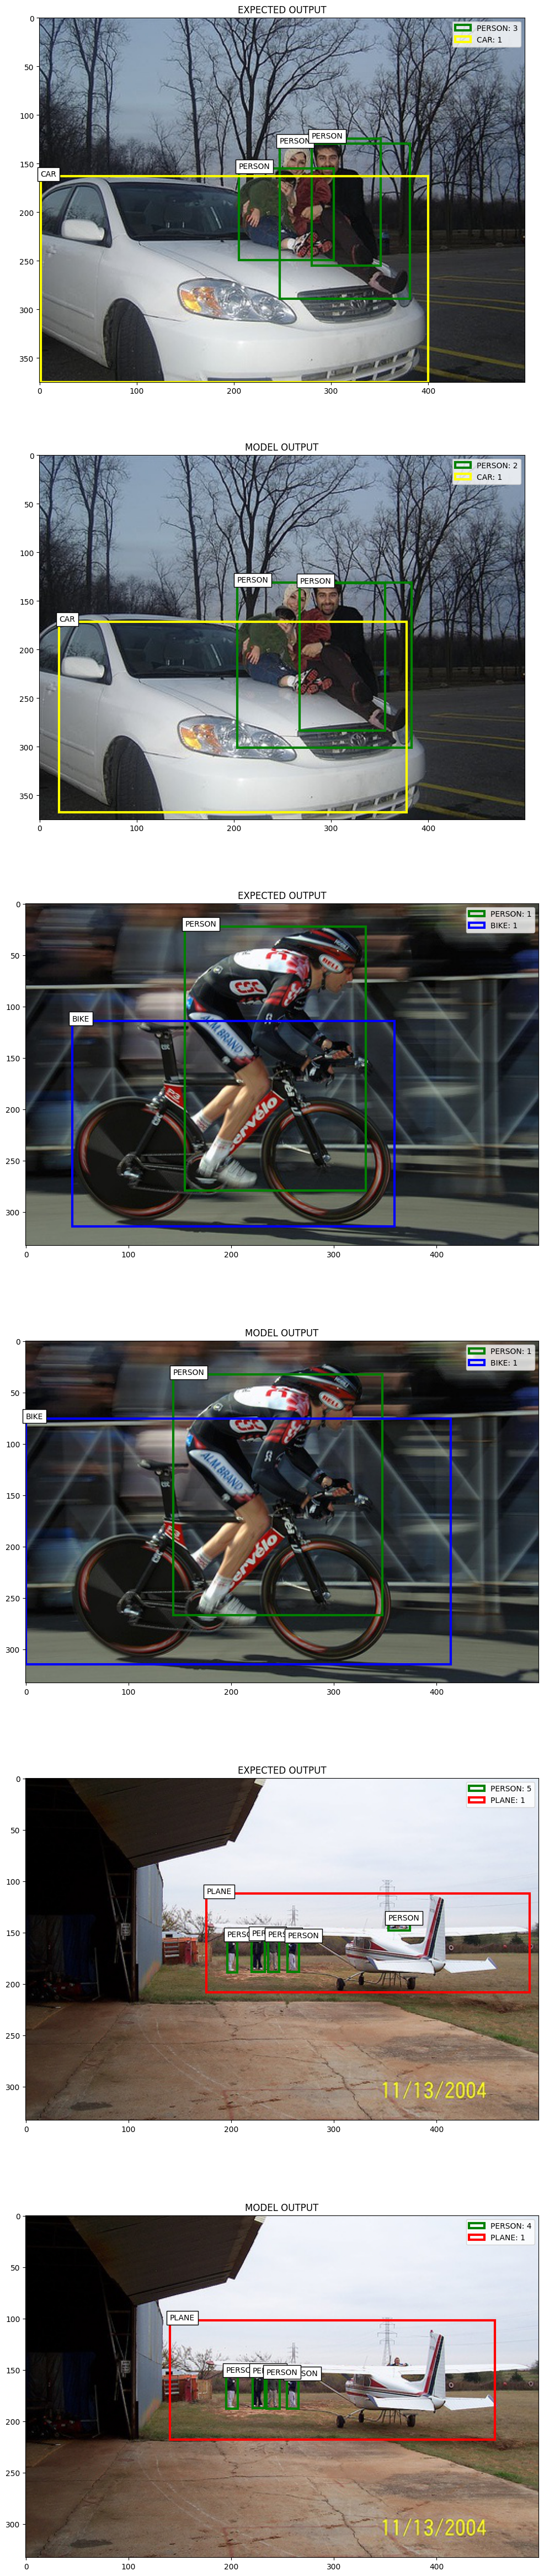

In [64]:
idxs = [50, 60, 70]

fig = plt.figure(figsize=(12,60))
fig.add_subplot(6,1,1)
plotBbox(testDs[idxs[0]][0], testDs[idxs[0]][1]['boxes'], testDs[idxs[0]][1]['labels'])
fig.add_subplot(6,1,3)
plotBbox(testDs[idxs[1]][0], testDs[idxs[1]][1]['boxes'], testDs[idxs[1]][1]['labels'])
fig.add_subplot(6,1,5)
plotBbox(testDs[idxs[2]][0], testDs[idxs[2]][1]['boxes'], testDs[idxs[2]][1]['labels'])

with torch.no_grad():
    img = output2image(testDs[idxs[0]][0])
    fig.add_subplot(6,1,2)
    plotBbox(testDs[idxs[0]][0], model(img)[0]['boxes'], model(img)[0]['labels'], model(img)[0]['scores'], 0.72)
    img = output2image(testDs[idxs[1]][0])
    fig.add_subplot(6,1,4)
    plotBbox(testDs[idxs[1]][0], model(img)[0]['boxes'], model(img)[0]['labels'], model(img)[0]['scores'], 0.72)
    img = output2image(testDs[idxs[2]][0])
    fig.add_subplot(6,1,6)
    plotBbox(testDs[idxs[2]][0], model(img)[0]['boxes'], model(img)[0]['labels'], model(img)[0]['scores'], 0.72)